## ORB: Una alternativa eficiente a SIFT o SURF



La correspondencia de características es fundamental en muchos problemas de visión artificial, como el reconocimiento de objetos o la estructura a partir del movimiento. Los métodos actuales se basan en descriptores costosos para la detección y la correspondencia. En este artículo, proponemos un descriptor binario muy rápido basado en BRIEF, llamado ORB, que es invariante a la rotación y resistente al ruido. Demostramos mediante experimentos que ORB es dos órdenes de magnitud más rápido que SIFT, con un rendimiento similar en muchas situaciones. Su eficiencia se prueba en diversas aplicaciones del mundo real, incluyendo la detección de objetos y el seguimiento de parches en un teléfono inteligente.

Artículo sobre el algoritmo orb: https://ieeexplore-ieee-org.bdigital.udistrital.edu.co/stamp/stamp.jsp?tp=&arnumber=6126544 

Este algoritmo fue desarrollado por Ethan Rublee, Vincent Rabaud, Kurt Konolige y Gary R. Bradski en su artículo "ORB: Una alternativa eficiente a SIFT o SURF" en 2011. Como indica el título, es una buena alternativa a SIFT y SURF en cuanto a coste computacional, rendimiento comparable y, principalmente, en cuanto a patentes SIFT y SURF están patentados.

Pasos del algoritmo ORB
---

#### 1. Detección de puntos clave con FAST

FAST (Features from Accelerated Segment Test) busca esquinas

* Sea $I \in \mathbb{R}^{H \times W}$ la imagen en escala de grises, con $H$ filas y $W$ columnas.

* Para un píxel central en posición $p = (x,y)$, se considera un círculo de 16 píxeles alrededor, por ejemplo:

$$
S_p = \{I_{x_i, y_i} \mid i=1,\dots,16 \}
$$

* Se define un umbral $t$.

* La condición para que $p$ sea una esquina es que exista un conjunto consecutivo de al menos $N$ píxeles en $S_p$ que sean todos **más claros** o todos **más oscuros** que $I_{x,y}$ en al menos $t$:

Matemáticamente:

$$
\exists \, i \text{ tal que } \forall j \in \{i, i+1, \dots, i+N-1\} \mod 16, \quad
\begin{cases}
I_{x_j, y_j} > I_{x,y} + t \quad &\text{(más claro)} \\
\text{o}\\
I_{x_j, y_j} < I_{x,y} - t \quad &\text{(más oscuro)}
\end{cases}
$$

* Este test se realiza para cada píxel $p$, obteniendo el conjunto de keypoints $K$.

---

#### 2. Cálculo de orientación del keypoint

Para cada punto clave $p = (x,y)$, se calcula su orientación $\theta_p$ para que el descriptor sea invariante a rotaciones.

* Se extrae un parche cuadrado $P_p$ centrado en $p$, de tamaño $S \times S$, con intensidades $I_{i,j}$.

* Se calculan los momentos de orden 1:

$$
m_{10} = \sum_{i,j} i \cdot I_{i,j}, \quad
m_{01} = \sum_{i,j} j \cdot I_{i,j}
$$

* La orientación es:

$$
\theta_p = \arctan2(m_{01}, m_{10})
$$

donde $\arctan2$ es la función arcotangente que devuelve el ángulo en radianes considerando el signo de ambos argumentos.

---

#### 3. Computación del descriptor BRIEF rotado

El descriptor BRIEF es un vector binario que codifica comparaciones de intensidades en pares de puntos dentro del parche.

* Se define un patrón fijo de pares de puntos $\{(p_i, q_i)\}_{i=1}^N$, con coordenadas relativas al centro del parche.

* Para que el descriptor sea invariante a rotación, los pares se rotan por $\theta_p$:

$$
p_i' = R_{\theta_p} p_i, \quad q_i' = R_{\theta_p} q_i
$$

donde

$$
R_{\theta} = \begin{bmatrix}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta
\end{bmatrix}
$$

* Para cada par $i$, se compara la intensidad de los píxeles rotados:

$$
\tau_i = \begin{cases}
1, & \text{si } I(p_i') < I(q_i') \\
0, & \text{en otro caso}
\end{cases}
$$

* El descriptor binario es:

$$
D_p = [\tau_1, \tau_2, \dots, \tau_N] \in \{0,1\}^N
$$

---

#### 4. Emparejamiento (Matching) entre descriptores

Dado dos descriptores $D_p$ y $D_q$, su distancia se mide con la **distancia de Hamming**:

$$
d_H(D_p, D_q) = \sum_{i=1}^N \mathbf{1}_{\tau_i^p \neq \tau_i^q}
$$

donde $\mathbf{1}_{\cdot}$ es la función indicadora que vale 1 si la condición es verdadera y 0 si es falsa.

Se buscan pares $(p, q)$ que minimicen $d_H(D_p, D_q)$.


A continuación se observa el diagrama de flujo del algoritmo

![alt text](diagrama-flujo.png)

## Así lo trabaja la libreria OPENCV


https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html

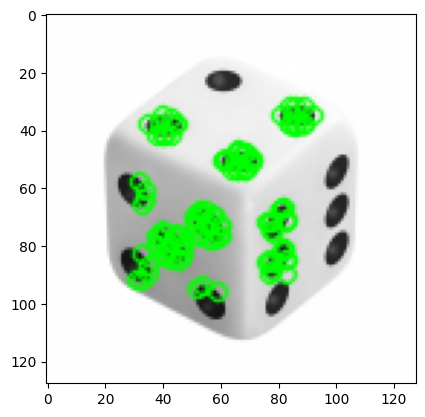

(<matplotlib.image.AxesImage at 0x111e3ef00>, None)

In [397]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
 
#Lectura de una imagen para encontrar sus descriptores con ORB de la imagen del dado
img = cv.imread('dado.png', cv.IMREAD_GRAYSCALE)
 
orb = cv.ORB_create()
 
kp = orb.detect(img,None)
 
kp, des = orb.compute(img, kp)

#dibujo de los keypoints
img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

## Código Micropython

El ejemplo anterior lo haremos usando micropython, para esto es importante el no uso de librerias y evitar funciones complejas que puedan requerir mucha memoria RAM por los recursos limitados en los microcontroladores

In [467]:

try:
    import utime as time
except ImportError:
    import time

try:
    _seed = time.ticks_ms()
except AttributeError:
    _seed = int(time.time() * 1000)

PI = 3.141592653589793
UMBRAL=30

def random():
    global _seed
    _seed = (_seed * 1103515245 + 12345) % (2**31)
    return _seed

def randint(a, b):
    return a + random() % (b - a + 1)

# Arcotangente, aproximación con serie de Taylor
def atan_series(z, terms=10):
    if abs(z) > 1:
        return (PI/2 if z > 0 else -PI/2) - atan_series(1/z, terms)
    
    result = 0
    sign = 1
    for n in range(terms):
        term = (z**(2*n + 1)) / (2*n + 1)
        result += sign * term
        sign *= -1
    return result

def atan2_taylor(y, x, terms=10):
    if x > 0:
        return atan_series(y/x, terms)
    elif x < 0 and y >= 0:
        return atan_series(y/x, terms) + PI
    elif x < 0 and y < 0:
        return atan_series(y/x, terms) - PI
    elif x == 0 and y > 0:
        return PI / 2
    elif x == 0 and y < 0:
        return -PI / 2
    else:
        return 0 

# Seno por serie de Taylor hasta el 7mo término
def sin(x):

    x = x % (2 * PI)
    if x > PI:
        x -= 2 * PI
    elif x < -PI:
        x += 2 * PI

    return x - (x**3)/6 + (x**5)/120 - (x**7)/5040

# Coseno por serie de Taylor hasta el termino 6
def cos(x):
    x = x % (2 * PI)
    if x > PI:
        x -= 2 * PI
    elif x < -PI:
        x += 2 * PI

    x2 = x * x
    return 1 - x2/2 + x2*x2/24 - x2*x2*x2/720


def radians(grado):
    return grado * PI / 180

#Implementación del algoritmo FAST
def detect_fast_corners(image, threshold=UMBRAL):
    
    keypoints = []
    #El algoritmo FAST busca cambios de intensidad en un circulo centrado en el punto con 16 puntos
    circle_offsets = [(0,-3), (1,-3), (2,-2), (3,-1), (3,0), (3,1), (2,2), (1,3),
                     (0,3), (-1,3), (-2,2), (-3,1), (-3,0), (-3,-1), (-2,-2), (-1,-3)]
    
    for y in range(6, len(image)-3):
        for x in range(6, len(image[0])-3):
            pixel = image[y][x]
            brighter = darker = 0
            # para dar mayor velocidad al algoritmo se busca en 4 puntos para verificar si existe cambios de intensidad en esas direcciones
            for i in [0, 4, 8, 12]:
                dy, dx = circle_offsets[i]
                if image[y+dy][x+dx] > pixel + threshold:
                    brighter += 1
                elif image[y+dy][x+dx] < pixel - threshold:
                    darker += 1
            # Si pasa la anterior verificación se revisa cada uno de los 16 puntos para verificar si es un punto clave
            if brighter >= 3 or darker >= 3:
                brighter = darker = 0
                for dy, dx in circle_offsets:
                    if image[y+dy][x+dx] > pixel + threshold:
                        brighter += 1
                    elif image[y+dy][x+dx] < pixel - threshold:
                        darker += 1
                #Si la suma de las diferencias entre el punto central y cada uno de los 16 puntos es mayor al treshhold en más de 12 puntos, significa que puede ser un buen candidato a punto clave y se almacena
                if brighter >= 12 or darker >= 12:
                    keypoints.append({'pt': (y, x), 'angle': 0})

    return keypoints

#Esta función calcula la orientación del cambio de intensidad usando la función arcotangente, es un punto que limitante al usar el algoritmo de FAST
def compute_orientation(image, keypoint):

    x, y = keypoint['pt']
    m01 = m10 = 0
    for i in range(-15, 16):
        for j in range(-15, 16):
            if 0 <= y+i < len(image) and 0 <= x+j < len(image[0]):
                m01 += i * image[y+i][x+j]
                m10 += j * image[y+i][x+j]
    angle=atan2_taylor(m01, m10) * 180 / PI
    return angle

#Funicón para encontrar el algoritmo de BRIEF, para encoentrar el keypoint
def brief_descriptor(image, keypoint, pattern):

    x, y = keypoint['pt']
    angle_rad = radians(keypoint['angle'])
    descriptor = []
    for x1, y1, x2, y2 in pattern:
        # Se rotan los puntos según el angulo
        x1_rot = x1 * cos(angle_rad) - y1 * sin(angle_rad)
        y1_rot = x1 * sin(angle_rad) + y1 * cos(angle_rad)
        x2_rot = x2 * cos(angle_rad) - y2 * sin(angle_rad)
        y2_rot = x2 * sin(angle_rad) + y2 * cos(angle_rad)
        # Comparación de intensidades (con verificación de bordes)
        val1 = image[int(y+y1_rot)][int(x+x1_rot)] if 0 <= int(y+y1_rot) < len(image) and 0 <= int(x+x1_rot) < len(image[0]) else 0
        val2 = image[int(y+y2_rot)][int(x+x2_rot)] if 0 <= int(y+y2_rot) < len(image) and 0 <= int(x+x2_rot) < len(image[0]) else 0
        descriptor.append(1 if val1 > val2 else 0)
    return descriptor

#Función para leer una imagen que debe provenir de un sensor, se simula con una lista 2d en valores 0-255 almacenados en un fichero .txt.
#Este fragemtno se cambia si tenemos acceso a un sensor de cámara
def leer_matriz(archivo):
    with open(archivo, 'r') as f:
        contenido = f.read()
        matriz = eval(contenido)  
    return matriz


#Ejecución del algoritmo de orb
def detecion_orb(archivo):
    #lectura del fichero
    matriz = leer_matriz(archivo)

    keypoints = detect_fast_corners(matriz)

    #Se revisa en un patron de 31 píxeles aleatorios al keypoint para verificar las posiciones clave x,y 
    pattern = [(randint(-15,15), randint(-15,15), randint(-15,15), randint(-15,15)) for _ in range(256)]

    #iteracion por todos los Keypoints para almacenar el angulo obtenido en cada keypoint asi como su descriptor BRIEF
    for kp in keypoints:
        
        kp['angle'] = compute_orientation(matriz, kp)

        descriptor = brief_descriptor(matriz, kp, pattern)
        kp['descriptor']=descriptor

    
    return keypoints


#Ejemplo leyendo la imagen del DADO
key=detecion_orb("imagen.txt")
key1=detecion_orb("imagen1.txt")

print("Total keypoints:", len(key))
print("Primeros 5 keypoints:", key[:5])


Total keypoints: 967
Primeros 5 keypoints: [{'pt': (23, 128), 'angle': -32.86408362609935, 'descriptor': [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0]}, {'pt': (23, 129), 'angle': -33.523009447407865, 'descriptor': [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1

El anterior código encuentra las caracterisiticas invariantes a escala y rotación para una imagen de entrada usando micropython, ahora con este sencillo algoritmo podemos encoentrar imágenes concordantes y darle aplicación de seguimiento de objetos e identificación de objsetos, para ello podemos comparar dos imagenes para ver si tienen las mismas caracteristicas.

Para revisar su resultado lo voy a mostrar con OPENCV

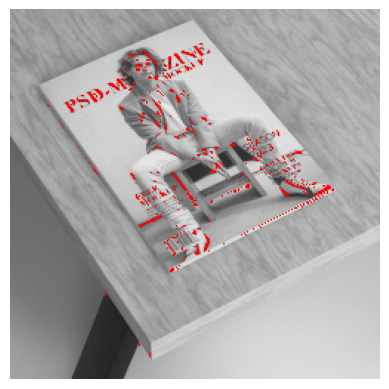

1


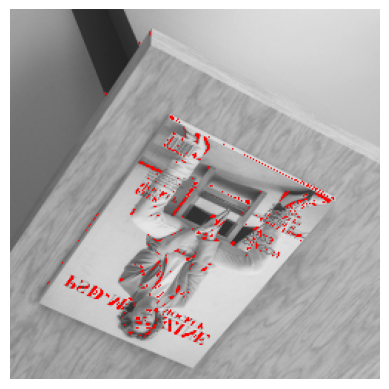

In [484]:
import cv2
import matplotlib.pyplot as plt

# Leer las imagenes
img = cv2.imread('revista.png', cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('revista1.png', cv2.IMREAD_GRAYSCALE)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

#se dibujan los keypoints en rojo
for i in range(len(key)):
    img_rgb[key[i]['pt'][0], key[i]['pt'][1]] = [255, 0, 0]

for i in range(len(key1)):
    img_rgb1[key1[i]['pt'][0], key1[i]['pt'][1]] = [255, 0, 0]

# Mostrar la imagen con matplotlib
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

print(1)

plt.imshow(img_rgb1)
plt.axis('off')
plt.show()

## Revisar puntos concordantes para detección de caracteristicas similares en dos imágenes

In [416]:
def hamming_distance(desc1, desc2):
    try:
        return sum(b1 != b2 for b1, b2 in zip(desc1, desc2))
    except TypeError as e:
        print("Error comparando:", desc1, desc2)
        raise e

matches = []
for i, d1 in enumerate(key):
    best_distance = 256  
    best_match = -1
    for j, d2 in enumerate(key1):
        dist = hamming_distance(d1['descriptor'], d2['descriptor'])
     
        if dist < best_distance:
            best_distance = dist
            best_match = j
    if best_distance < 100:  
        print(best_distance)
        matches.append((i, best_match))

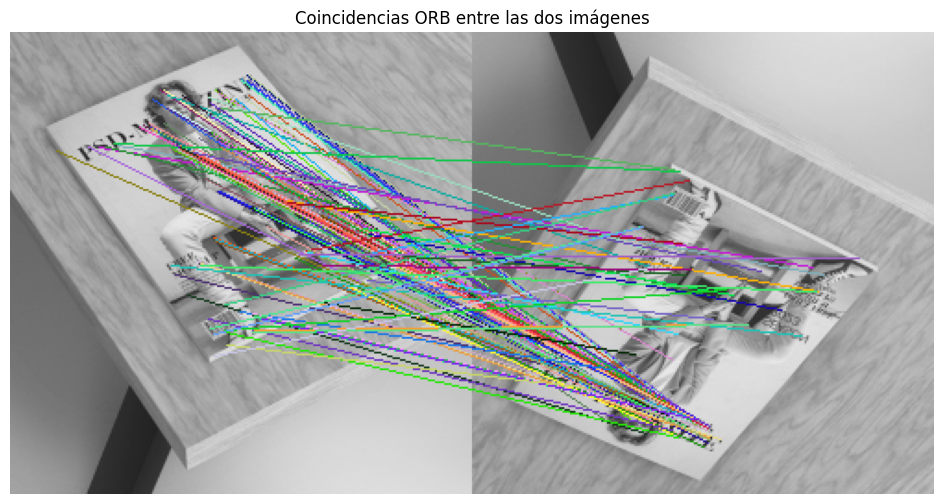

In [480]:
import matplotlib.pyplot as plt
import random
import cv2

#
# Imágenes originales
img1_gray = cv2.imread('revista.png', cv2.IMREAD_GRAYSCALE)
img2_gray = cv2.imread('revista1.png', cv2.IMREAD_GRAYSCALE)

# Imágenes a color para dibujar líneas
img1_color = cv2.cvtColor(img1_gray, cv2.COLOR_GRAY2BGR)
img2_color = cv2.cvtColor(img2_gray, cv2.COLOR_GRAY2BGR)

# Convertimos a color las imágenes en escala de grises
img_match_vis = cv2.hconcat([img1_color, img2_color])

for i1, i2 in matches:
    # Invertimos el orden de (y, x) -> (x, y) para OpenCV
    x1, y1 = key[i1]['pt'][1], key[i1]['pt'][0]
    x2, y2 = key1[i2]['pt'][1], key1[i2]['pt'][0]

    # Ajustamos la coordenada x2 al segundo panel de la imagen unida
    x2 += img1_gray.shape[1]

    # Color aleatorio para cada línea
    color = tuple([random.randint(0, 255) for _ in range(3)])

    # Dibujar línea
    cv2.line(img_match_vis, (x1, y1), (x2, y2), color, 1)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(img_match_vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Coincidencias ORB entre las dos imágenes")
plt.show()


## Verificación del uso de RAM de la fucnión de ORB implementada

Esta prueba es una estimación ya que depende del microcontrolador y recursos disponibles, esta prueba acá se usa desde un ambiente local usando Python

In [410]:
import tracemalloc
import time

tracemalloc.start()

start_time = time.time()

resultado=detecion_orb("imagen.txt")

end_time = time.time()
elapsed_time = end_time - start_time

snapshot = tracemalloc.take_snapshot()

stats = snapshot.statistics('filename')

total_mem = sum(stat.size for stat in stats) / 1024  # en KB

print(f"Resultado función: {resultado}")
print(f"Tiempo de ejecución: {elapsed_time:.4f} segundos")
print(f"Memoria usada total: {total_mem:.2f} KB")

tracemalloc.stop()


Resultado función: [{'pt': (20, 61), 'angle': -179.3497359814165, 'descriptor': [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]}, {'pt': (20, 62), 'angle': 178.620128197565, 'descriptor': [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 